In [1]:
from propagation import fresnel_propagation
from propagation_LP import fresnel_propagation as fresnel_lp
from focal_spot_pattern import create_gaussian_mask

import numpy as np
import matplotlib.pyplot as plt
import LightPipes as lp
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
# initial simulation settings
grid_dimension = 1000
grid_size = 500e-6

gauss_width = 70e-6

wavelength = 2.75e-10
z = 1
k = 2 * np.pi / wavelength

dx = grid_size/grid_dimension

x = dx * np.arange(-int(grid_dimension/2), grid_dimension-int(grid_dimension/2))
y = dx * np.arange(-int(grid_dimension/2), grid_dimension-int(grid_dimension/2))
X, Y = np.meshgrid(x,y)

I0 = 1e6

In [3]:
print("Fresnel check...")
print(f"N_f = {np.pi*gauss_width**2/(wavelength*z)}\n")

print("Sampling conditions?")
fx = np.fft.fftshift(np.fft.fftfreq(grid_dimension, d=dx))
print(bool(fx[1]-fx[0] <= 1/(wavelength*z*2*np.max(np.abs(fx)))))

Fresnel check...
N_f = 55.97746910032722

Sampling conditions?
False


## Uniform Phase

### Intensity

In [4]:
# computing theoretical waist value after propagation
def w(w0, lambda_, z):
    return w0 * np.sqrt(1 + (lambda_*z/(np.pi*w0*w0))**2)

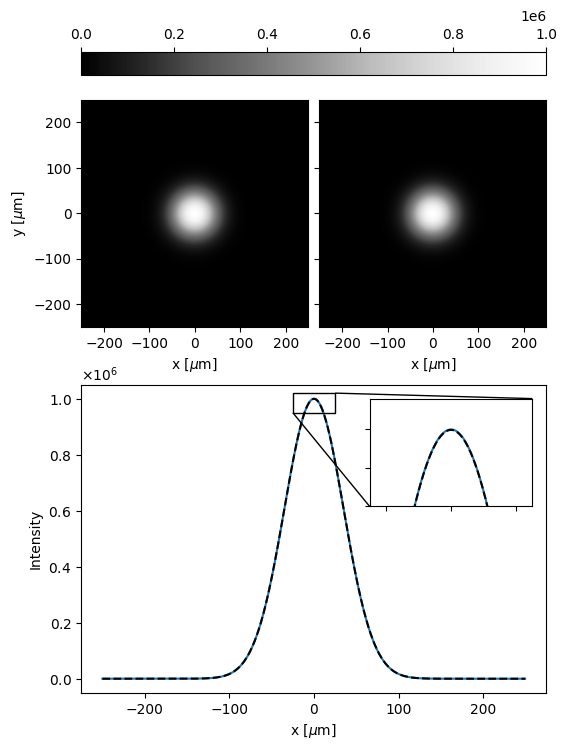

Tests for energy conservation...
START: 30787608005.123615
END: 30787608005.123154


In [5]:
# theoretical solutions
theoretical_start = I0 * np.exp(-2*(X**2+Y**2)/(gauss_width*gauss_width))
theoretical_prop = I0 * (gauss_width/w(gauss_width, wavelength, z))**2 * np.exp(-2*(X**2+Y**2)/(w(gauss_width, wavelength, z)**2))

fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(theoretical_start), np.min(theoretical_prop)])
vmax = np.max([np.max(theoretical_start), np.max(theoretical_prop)])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(theoretical_start, extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(theoretical_prop, extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(x*1e6, theoretical_start[int(len(theoretical_start)/2)])
ax3.plot(x*1e6, theoretical_prop[int(len(theoretical_prop)/2)], color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Intensity")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True

axins = inset_axes(ax3, width="35%", height="35%", loc='upper right', borderpad=1)
axins.plot(x*1e6, theoretical_start[int(len(theoretical_start)/2)])
axins.plot(x*1e6, theoretical_prop[int(len(theoretical_prop)/2)], '--', c="black")

axins.tick_params(labelleft=False,labelbottom=False)

# Set the x and y limits for the inset
x1, x2, y1, y2 = -25, 25, 0.95e6, 1.02e6  # Customize this to zoom into the area of interest
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

mark_inset(ax3, axins, loc1=3, loc2=1, fc="none", ec="0",zorder=10)

plt.show()

print("Tests for energy conservation...")
print(f"START: {np.sum(theoretical_start)}")
print(f"END: {np.sum(theoretical_prop)}")

[[4.20116147e-21+0.j 4.35996926e-13+0.j 8.93850355e-13+0.j ...
  1.37460496e-12+0.j 8.93850355e-13+0.j 4.35996926e-13+0.j]
 [4.35996926e-13+0.j 8.94792423e-13+0.j 1.37658732e-12+0.j ...
  1.88248091e-12+0.j 1.37658732e-12+0.j 8.94792423e-13+0.j]
 [8.93850355e-13+0.j 1.37658732e-12+0.j 1.88352387e-12+0.j ...
  2.41581666e-12+0.j 1.88352387e-12+0.j 1.37658732e-12+0.j]
 ...
 [1.37460496e-12+0.j 1.88248091e-12+0.j 2.41581666e-12+0.j ...
  2.97582911e-12+0.j 2.41581666e-12+0.j 1.88248091e-12+0.j]
 [8.93850355e-13+0.j 1.37658732e-12+0.j 1.88352387e-12+0.j ...
  2.41581666e-12+0.j 1.88352387e-12+0.j 1.37658732e-12+0.j]
 [4.35996926e-13+0.j 8.94792423e-13+0.j 1.37658732e-12+0.j ...
  1.88248091e-12+0.j 1.37658732e-12+0.j 8.94792423e-13+0.j]]


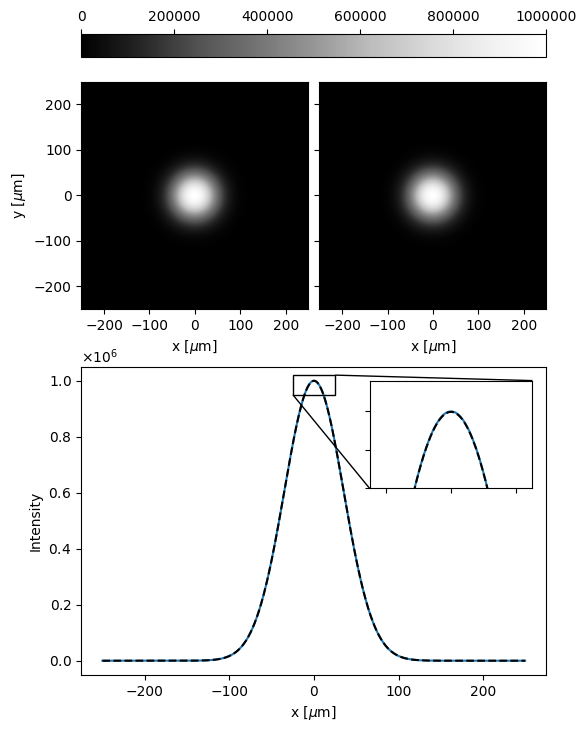

Tests for energy conservation...
START: 30787608004.09681
END: 30787608004.096806


In [6]:
# custom code
E_in = np.sqrt(I0)*np.ones((grid_dimension, grid_dimension), dtype=np.complex128)
E_in *= create_gaussian_mask(X, Y, gauss_width)-8.33794709e-12

print(E_in/np.sqrt(I0))

E_out, start, end = fresnel_propagation(E_in, wavelength, z, dx)
E_out = E_out[start:end, start:end]

fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(np.abs(E_in)**2), np.min(np.abs(E_out)**2)])
vmax = np.max([np.max(np.abs(E_in)**2), np.max(np.abs(E_out)**2)])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(np.abs(E_in)**2, extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(np.abs(E_out)**2, extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(x*1e6, np.abs(E_in[int(len(E_in)/2)])**2)
ax3.plot(x*1e6, np.abs(E_out[int(len(E_out)/2)])**2, color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Intensity")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True
# ax3.axhline(y=1/(np.exp(1)**2)*I0)
# ax3.axvline(x=gauss_width)

axins = inset_axes(ax3, width="35%", height="35%", loc='upper right', borderpad=1)
axins.plot(x*1e6, np.abs(E_in[int(len(E_in)/2)])**2)
axins.plot(x*1e6, np.abs(E_out[int(len(E_out)/2)])**2, '--', c="black")

axins.tick_params(labelleft=False,labelbottom=False)

# Set the x and y limits for the inset
x1, x2, y1, y2 = -25, 25, 0.95e6, 1.02e6  # Customize this to zoom into the area of interest
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

mark_inset(ax3, axins, loc1=3, loc2=1, fc="none", ec="0",zorder=10)

plt.show()

print("Tests for energy conservation...")
print(f"START: {np.sum(np.abs(E_in)**2)}")
print(f"END: {np.sum(np.abs(E_out)**2)}")

E_out_copy = E_out.copy()

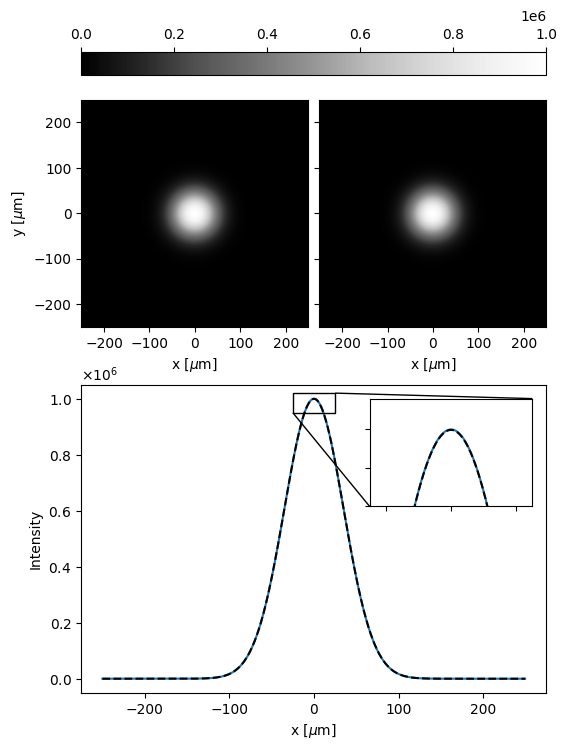

Tests for energy conservation...
START: 30787608005.123615
END: 30787608005.123634
1.0000000000000007


In [7]:
LP_in = lp.Begin(grid_size, wavelength, grid_dimension, dtype=np.complex128)
LP_in.field *= np.sqrt(I0)
LP_in = lp.GaussAperture(LP_in, 1/np.sqrt(2)*gauss_width)

LP_out = lp.Forvard(LP_in, z)

fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(np.abs(LP_in.field)**2), np.min(np.abs(LP_out.field)**2)])
vmax = np.max([np.max(np.abs(LP_in.field)**2), np.max(np.abs(LP_out.field)**2)])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(np.abs(LP_in.field)**2, extent=(np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6, np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(np.abs(LP_out.field)**2, extent=(np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6, np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(LP_in.xvalues*1e6, np.abs(LP_in.field[int(len(LP_in.field)/2)])**2)
ax3.plot(LP_in.xvalues*1e6, np.abs(LP_out.field[int(len(LP_out.field)/2)])**2, color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Intensity")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True
# ax3.axhline(y=1/(np.exp(1)**2)*I0)
# ax3.axvline(x=gauss_width)

axins = inset_axes(ax3, width="35%", height="35%", loc='upper right', borderpad=1)
axins.plot(LP_in.xvalues*1e6, np.abs(LP_in.field[int(len(LP_in.field)/2)])**2)
axins.plot(LP_in.xvalues*1e6, np.abs(LP_out.field[int(len(LP_out.field)/2)])**2, '--', c="black")

axins.tick_params(labelleft=False,labelbottom=False)

# Set the x and y limits for the inset
x1, x2, y1, y2 = -25, 25, 0.95e6, 1.02e6  # Customize this to zoom into the area of interest
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

mark_inset(ax3, axins, loc1=3, loc2=1, fc="none", ec="0",zorder=10)

plt.show()

print("Tests for energy conservation...")
print(f"START: {np.sum(np.abs(LP_in.field)**2)}")
print(f"END: {np.sum(np.abs(LP_out.field)**2)}")
print(np.sum(np.abs(LP_out.field)**2)/np.sum(np.abs(LP_in.field)**2))

### Full field

In [8]:
theoretical_start_2 = np.sqrt(I0) * np.exp(-(X**2+Y**2)/(gauss_width*gauss_width))

In [9]:
def zR(w0, lambda_):
    return np.pi*w0*w0/lambda_

# computing theoretical waist value after propagation
def w(w0, lambda_, z):
    return w0 * np.sqrt(1 + (lambda_*z/(np.pi*w0*w0))**2)

def final_field(x, y, I0, w0, z, lambda_):
    ww = w(w0, lambda_, z)
    zzR = zR(w0, lambda_)
    R = z * (1 + (zzR/z)**2)
    psi = np.atan2(z, zzR)
    print(psi)

    return np.sqrt(I0) * w0/ww * np.exp(-(x**2+y**2)/(ww*ww)) * np.exp(-1j * (k*z + k*(x**2+y**2)/(2*R) - psi))

In [10]:
theoretical_prop_2 = final_field(X, Y, I0, gauss_width, z, wavelength)

0.01786243033733853


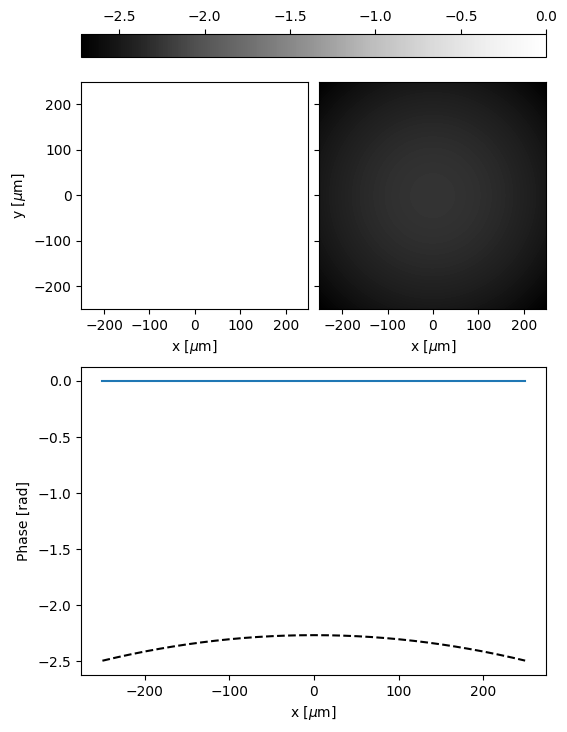

In [11]:
fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(np.angle(theoretical_start_2)), np.min(np.angle(theoretical_prop_2))])
vmax = np.max([np.max(np.angle(theoretical_start_2)), np.max(np.angle(theoretical_prop_2))])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(np.angle(theoretical_start_2), extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(np.angle(theoretical_prop_2), extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(x*1e6, np.angle(theoretical_start_2[int(len(theoretical_start_2)/2)]))
ax3.plot(x*1e6, np.angle(theoretical_prop_2[int(len(theoretical_prop_2)/2)]), color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Phase [rad]")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True

plt.show()

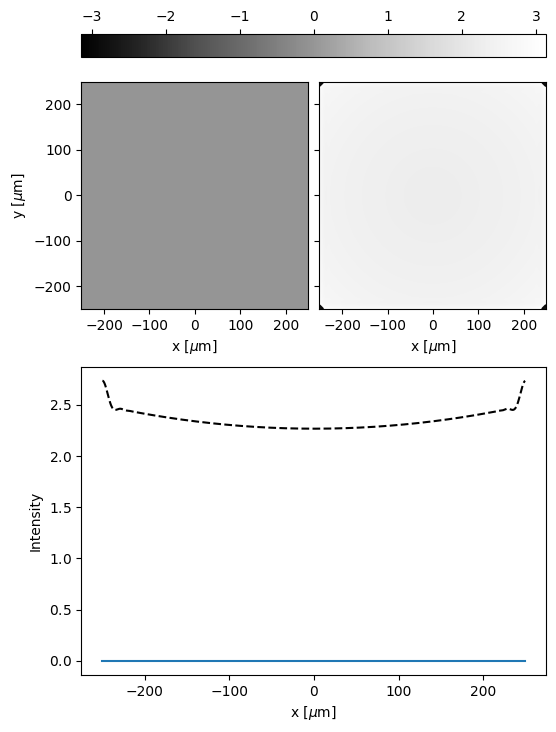

In [12]:
fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(np.angle(E_in)), np.min(np.angle(E_out))])
vmax = np.max([np.max(np.angle(E_in)), np.max(np.angle(E_out))])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(np.angle(E_in), extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(np.angle(E_out), extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(x*1e6, np.angle(E_in[int(len(E_in)/2)]))
ax3.plot(x*1e6, np.angle(E_out[int(len(E_out)/2)]), color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Intensity")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True
# ax3.axhline(y=1/(np.exp(1))*I0)
# ax3.axvline(x=gauss_width)

plt.show()

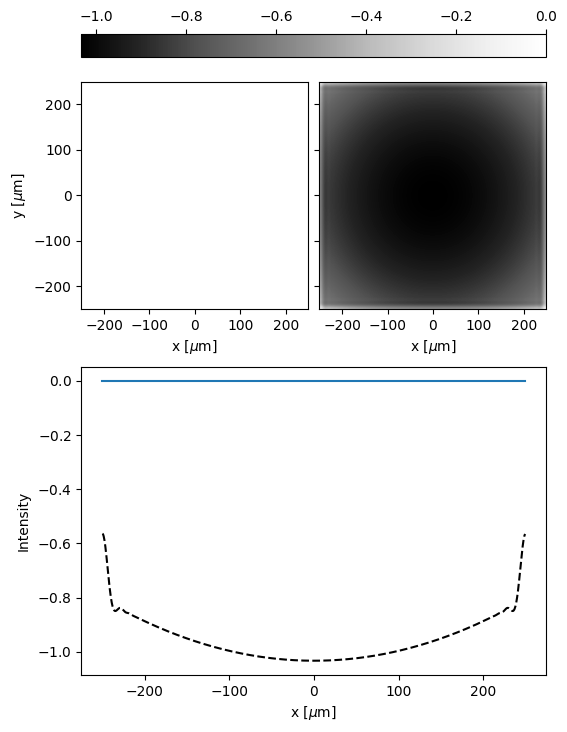

In [13]:
fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(np.angle(LP_in.field)), np.min(np.angle(LP_out.field))])
vmax = np.max([np.max(np.angle(LP_in.field)), np.max(np.angle(LP_out.field))])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(np.angle(LP_in.field), extent=(np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6, np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(np.angle(LP_out.field), extent=(np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6, np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(LP_in.xvalues*1e6, np.angle(LP_in.field[int(len(LP_in.field)/2)]))
ax3.plot(LP_in.xvalues*1e6, np.angle(LP_out.field[int(len(LP_out.field)/2)]), color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Intensity")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True
# ax3.axhline(y=1/(np.exp(1))*I0)
# ax3.axvline(x=gauss_width)

plt.show()

## Randomized Phase

### Intensity

In [14]:
def zR(w0, lambda_):
    return np.pi*w0*w0/lambda_

# computing theoretical waist value after propagation
def w(w0, lambda_, z):
    return w0 * np.sqrt(1 + (lambda_*z/(np.pi*w0*w0))**2)

def final_field(x, y, I0, w0, z, lambda_, random_phase):
    ww = w(w0, lambda_, z)
    zzR = zR(w0, lambda_)
    R = z * (1 + (zzR/z)**2)
    psi = np.atan2(z, zzR)
    print(psi)

    return np.sqrt(I0) * w0/ww * np.exp(-(x**2+y**2)/(ww*ww)) * np.exp(-1j * (k*z + k*(x**2+y**2)/(2*R) - psi - random_phase))

In [15]:
random_phase = np.random.uniform(-np.pi, np.pi, (grid_dimension, grid_dimension))

0.01786243033733853


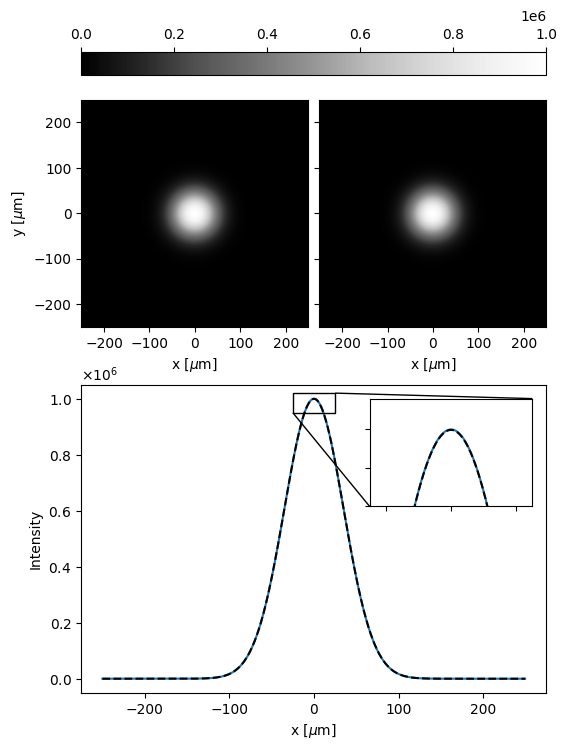

Tests for energy conservation...
START: 30787608005.123615
END: 30787608005.123154


In [16]:
# theoretical solutions
theoretical_start = np.sqrt(I0) * np.exp(-(X**2+Y**2)/(gauss_width*gauss_width)) * np.exp(1j * random_phase)
theoretical_prop = final_field(X, Y, I0, gauss_width, z, wavelength, random_phase)

fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(np.abs(theoretical_start)**2), np.min(np.abs(theoretical_prop)**2)])
vmax = np.max([np.max(np.abs(theoretical_start)**2), np.max(np.abs(theoretical_prop)**2)])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(np.abs(theoretical_start)**2, extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(np.abs(theoretical_prop)**2, extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(x*1e6, np.abs(theoretical_start[int(len(theoretical_start)/2)])**2)
ax3.plot(x*1e6, np.abs(theoretical_prop[int(len(theoretical_prop)/2)])**2, color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Intensity")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True

axins = inset_axes(ax3, width="35%", height="35%", loc='upper right', borderpad=1)
axins.plot(x*1e6, np.abs(theoretical_start[int(len(theoretical_start)/2)])**2)
axins.plot(x*1e6, np.abs(theoretical_prop[int(len(theoretical_prop)/2)])**2, '--', c="black")

axins.tick_params(labelleft=False,labelbottom=False)

# Set the x and y limits for the inset
x1, x2, y1, y2 = -25, 25, 0.95e6, 1.02e6  # Customize this to zoom into the area of interest
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

mark_inset(ax3, axins, loc1=3, loc2=1, fc="none", ec="0",zorder=10)

plt.show()

print("Tests for energy conservation...")
print(f"START: {np.sum(np.abs(theoretical_start)**2)}")
print(f"END: {np.sum(np.abs(theoretical_prop)**2)}")

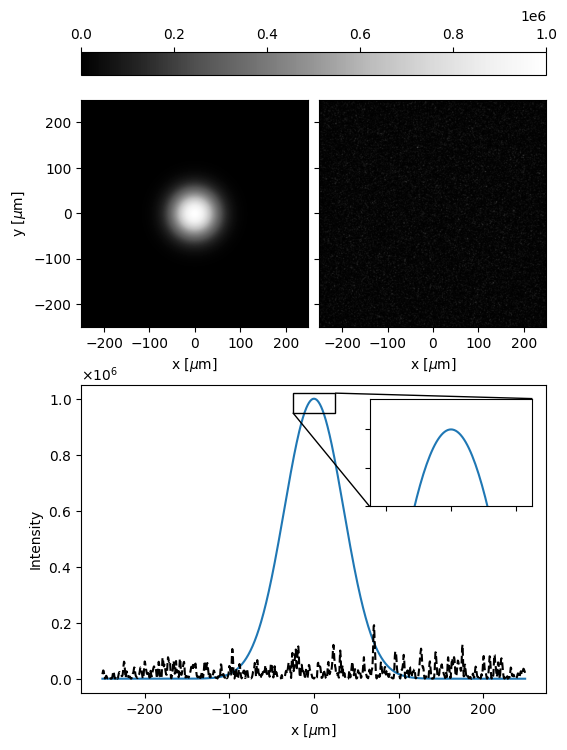

Tests for energy conservation...
START: 30787608005.123615
END: 24454619489.42073


In [17]:
# custom code
E_in = np.sqrt(I0)*np.ones((grid_dimension, grid_dimension), dtype=np.complex128)
E_in *= create_gaussian_mask(X, Y, gauss_width) * np.exp(1j * random_phase)

E_out, start, end = fresnel_propagation(E_in, wavelength, z, dx, padding_factor=10)
E_out = E_out[start:end, start:end]

fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(np.abs(E_in)**2), np.min(np.abs(E_out)**2)])
vmax = 1e6 #np.max([np.max(np.abs(E_in)**2), np.max(np.abs(E_out)**2)])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(np.abs(E_in)**2, extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(np.abs(E_out)**2, extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(x*1e6, np.abs(E_in[int(len(E_in)/2)])**2)
ax3.plot(x*1e6, np.abs(E_out[int(len(E_out)/2)])**2, color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Intensity")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True
# ax3.axhline(y=1/(np.exp(1)**2)*I0)
# ax3.axvline(x=gauss_width)

axins = inset_axes(ax3, width="35%", height="35%", loc='upper right', borderpad=1)
axins.plot(x*1e6, np.abs(E_in[int(len(E_in)/2)])**2)
axins.plot(x*1e6, np.abs(E_out[int(len(E_out)/2)])**2, '--', c="black")

axins.tick_params(labelleft=False,labelbottom=False)

# Set the x and y limits for the inset
x1, x2, y1, y2 = -25, 25, 0.95e6, 1.02e6  # Customize this to zoom into the area of interest
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

mark_inset(ax3, axins, loc1=3, loc2=1, fc="none", ec="0",zorder=10)

plt.show()

print("Tests for energy conservation...")
print(f"START: {np.sum(np.abs(E_in)**2)}")
print(f"END: {np.sum(np.abs(E_out)**2)}")

E_out_copy = E_out.copy()

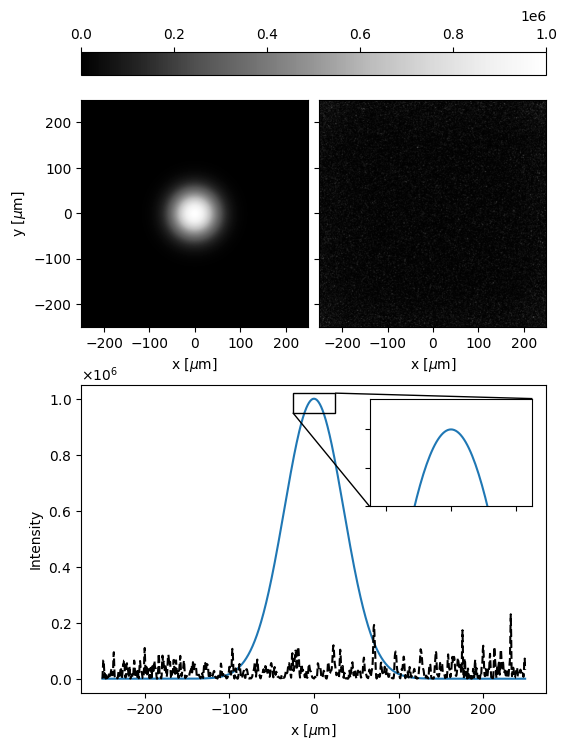

Tests for energy conservation...
START: 30787608005.12361
END: 30787608005.12365
1.0000000000000013


In [18]:
LP_in = lp.Begin(grid_size, wavelength, grid_dimension, dtype=np.complex128)
LP_in.field *= np.sqrt(I0) * np.exp(1j * random_phase)
LP_in = lp.GaussAperture(LP_in, 1/np.sqrt(2)*gauss_width)

LP_out = lp.Forvard(LP_in, z)

fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(np.abs(LP_in.field)**2), np.min(np.abs(LP_out.field)**2)])
vmax = 1e6 #np.max([np.max(np.abs(LP_in.field)**2), np.max(np.abs(LP_out.field)**2)])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(np.abs(LP_in.field)**2, extent=(np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6, np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(np.abs(LP_out.field)**2, extent=(np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6, np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(LP_in.xvalues*1e6, np.abs(LP_in.field[int(len(LP_in.field)/2)])**2)
ax3.plot(LP_in.xvalues*1e6, np.abs(LP_out.field[int(len(LP_out.field)/2)])**2, color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Intensity")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True
# ax3.axhline(y=1/(np.exp(1)**2)*I0)
# ax3.axvline(x=gauss_width)

axins = inset_axes(ax3, width="35%", height="35%", loc='upper right', borderpad=1)
axins.plot(LP_in.xvalues*1e6, np.abs(LP_in.field[int(len(LP_in.field)/2)])**2)
axins.plot(LP_in.xvalues*1e6, np.abs(LP_out.field[int(len(LP_out.field)/2)])**2, '--', c="black")

axins.tick_params(labelleft=False,labelbottom=False)

# Set the x and y limits for the inset
x1, x2, y1, y2 = -25, 25, 0.95e6, 1.02e6  # Customize this to zoom into the area of interest
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

mark_inset(ax3, axins, loc1=3, loc2=1, fc="none", ec="0",zorder=10)

plt.show()

print("Tests for energy conservation...")
print(f"START: {np.sum(np.abs(LP_in.field)**2)}")
print(f"END: {np.sum(np.abs(LP_out.field)**2)}")
print(np.sum(np.abs(LP_out.field)**2)/np.sum(np.abs(LP_in.field)**2))

### Full field

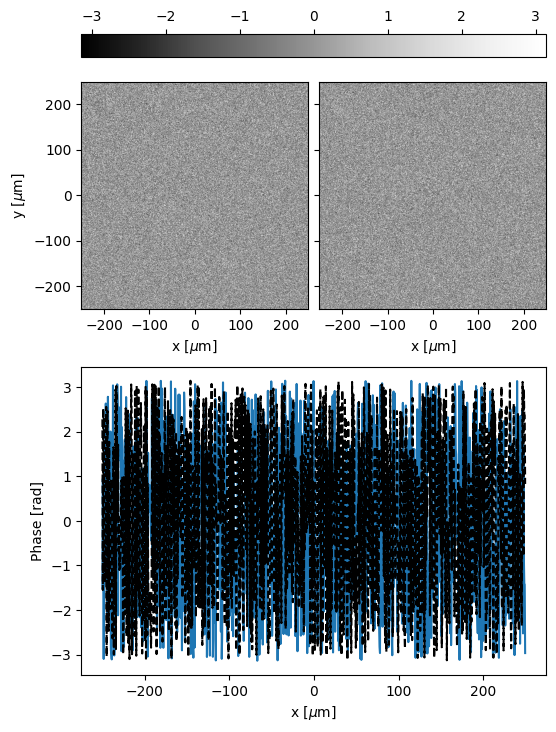

In [19]:
fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(np.angle(theoretical_start)), np.min(np.angle(theoretical_prop))])
vmax = np.max([np.max(np.angle(theoretical_start)), np.max(np.angle(theoretical_prop))])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(np.angle(theoretical_start), extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(np.angle(theoretical_prop), extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(x*1e6, np.angle(theoretical_start[int(len(theoretical_start)/2)]))
ax3.plot(x*1e6, np.angle(theoretical_prop[int(len(theoretical_prop)/2)]), color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Phase [rad]")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True

plt.show()

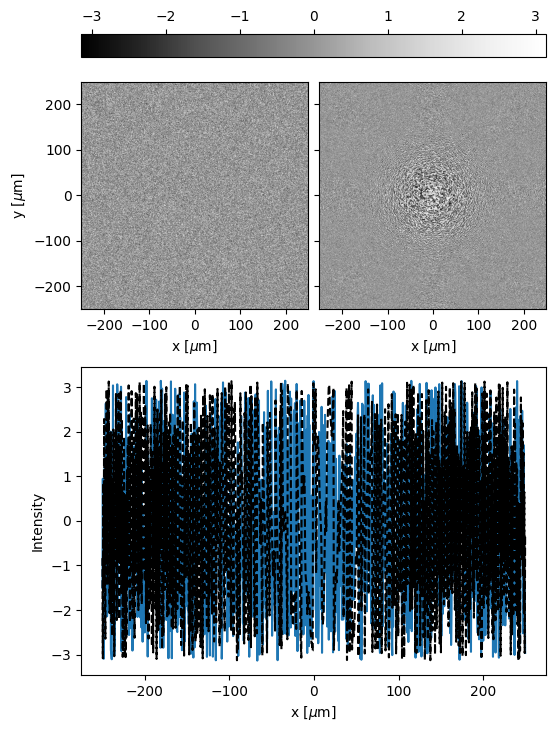

In [20]:
fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(np.angle(E_in)), np.min(np.angle(E_out))])
vmax = np.max([np.max(np.angle(E_in)), np.max(np.angle(E_out))])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(np.angle(E_in), extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(np.angle(E_out), extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(x*1e6, np.angle(E_in[int(len(E_in)/2)]))
ax3.plot(x*1e6, np.angle(E_out[int(len(E_out)/2)]), color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Intensity")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True
# ax3.axhline(y=1/(np.exp(1))*I0)
# ax3.axvline(x=gauss_width)

plt.show()

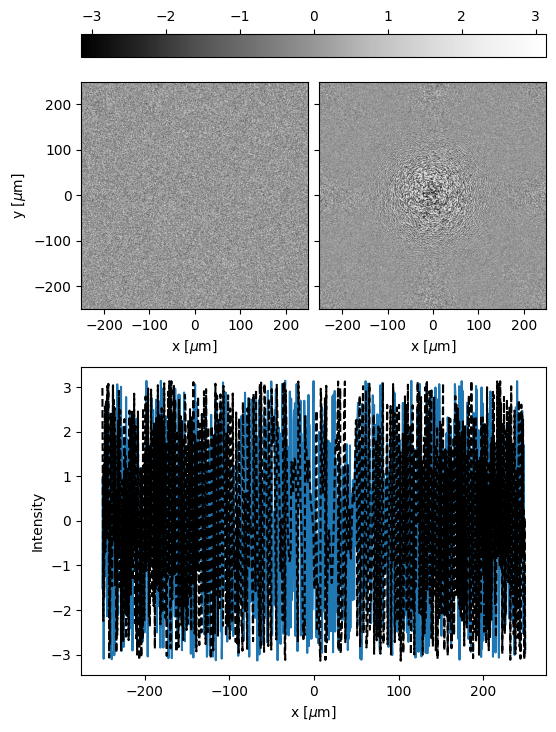

In [21]:
fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(np.angle(LP_in.field)), np.min(np.angle(LP_out.field))])
vmax = np.max([np.max(np.angle(LP_in.field)), np.max(np.angle(LP_out.field))])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(np.angle(LP_in.field), extent=(np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6, np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(np.angle(LP_out.field), extent=(np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6, np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(LP_in.xvalues*1e6, np.angle(LP_in.field[int(len(LP_in.field)/2)]))
ax3.plot(LP_in.xvalues*1e6, np.angle(LP_out.field[int(len(LP_out.field)/2)]), color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Intensity")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True
# ax3.axhline(y=1/(np.exp(1))*I0)
# ax3.axvline(x=gauss_width)

plt.show()